In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import numba as nb
from numba import jit, njit, vectorize, float64, int64, prange

import time


In this notebook I'll draft two N-body models the two galaxies. We can change this notebook and modify it into a script later on

In [23]:
#parameters and initial conditions
M1 = 1.0       #mass of stationary galaxy (target galaxy)
M2 = (2/3)*M1  #mass of moving galaxy (projectile galaxy)
G = 1.0        #gravitational constant
r0 = 1.0       #r0 from the papaer (I forgot what it was lol)

#TODO: determine time/timestep units and timelenght 
#TODO: Determine the units for G, and distances (r0). Possibly kpc and Myr? or maube set G = 1 and use r0 in AU? who knows lol

num_rings = 16
particles_per_ring = 32

In [26]:
#Lets create the N-Body system for Target galaxy. Lets do 16 rows just like in the paper for now.

M1_pos = np.array([0.0, 0.0, 0.0]) #(x,y,z)
M2_pos = np.array([0.0, 0.0, 10.0]) #at arbitary distance away from the target galaxy

# Initial velocities of the galaxies
M1_vel = np.array([0.0, 0.0, 0.0]) #(vx,vy,vz)
M2_vel = np.array([0.0, 0.0, -1.0]) #at arbitary velocity towards the target galaxy

#Merge the massive bodies into one array
massive_bodies = np.array([M1_pos, M2_pos])
massive_bodies_vel = np.array([M1_vel, M2_vel])

In [39]:
# Initialize arrays for particle positions and velocities
ring_positions = np.zeros((num_rings * particles_per_ring, 3))

# mean (mu) and standard deviation (sigma)
mu = 8.5    # center of distribution (half of 16)
sigma = 3.0  # standard deviation, which controls the spread of the distribution

ring_radii = np.random.normal(mu, sigma, num_rings)

#for positive radii
ring_radii = np.abs(ring_radii)

# Distribute particles in rings
for i in range(num_rings):
    for j in range(particles_per_ring):
        # Calculate position in polar coordinates
        theta = 2 * np.pi * j / particles_per_ring
        r = ring_radii[i]
        
        # Convert to Cartesian coordinates
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        z = 0.0
        
        # Store position in array
        ring_positions[i * particles_per_ring + j] = [x, y, z]  # Use 3 components here


In [30]:
#lets give a volocity to each particle in the rings so that they are in circular orbits
ring_velocities = np.zeros((num_rings * particles_per_ring, 3))

# Calculate circular velocity of each ring
ring_vels = np.sqrt(G * M1 / ring_radii)

# Set initial velocities of particles in rings
for i in range(num_rings):
    for j in range(particles_per_ring):
        # Calculate position in polar coordinates
        theta = 2 * np.pi * j / particles_per_ring
        v = ring_vels[i]
        
        
        # Convert to Cartesian coordinates
        vx = v * np.sin(theta)
        vy = v * np.cos(theta)
        vz = 0.0
        
        # Store velocity in array
        ring_velocities[i * particles_per_ring + j] = [vx, vy, vz]  # Use 3 components here

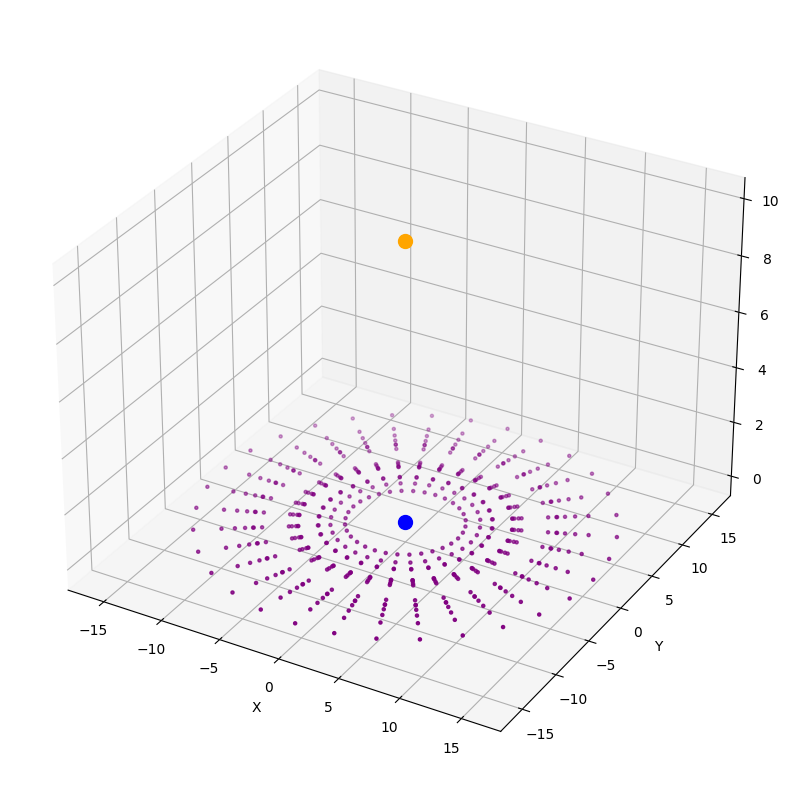

In [40]:
# 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.scatter(ring_positions[:, 0], ring_positions[:, 1], ring_positions[:, 2], c="purple", s=5)
ax.scatter(M1_pos[0], M1_pos[1], M1_pos[2], c="blue", s=100)
ax.scatter(M2_pos[0], M2_pos[1], M2_pos[2], c="orange", s=100)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()